In [3]:
from IPython.core.interactiveshell import InteractiveShell
import os
import sys
import gc
from time import time, sleep
from functools import partial
import pickle
from torch import multiprocessing as multiprocessing
import pixiedust as pxdb
import PIL
import cv2
from matplotlib import pyplot as plt
import seaborn as sns
from collections import OrderedDict as ODict
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# PYTORCH
import torch as tc
import torchvision as tcvis
from torchvision import transforms
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.dataset import Dataset
from torch import nn, optim
from torch.nn import functional as fu
from torch.autograd import Variable
# TORCH HELPERS
from albumentations import *
from ignite.engine import Engine, Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss
import hiddenlayer as hl
from torchsummary import summary
from tqdm import tqdm_notebook as tqdm

InteractiveShell.ast_node_interactivity = 'all'

# %pixie_debugger
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set(style='white', context='notebook', palette='tab10')
%config IPCompleter.greedy = True
%config IPCompleter.use_jedi = True


basepath = '/home/alk/Documents/Git/Kaggles/MNIST'
try:
    os.chdir(basepath)
    print(os.getcwd())
except NotADirectoryError:
    pass

/home/alk/Documents/Git/Kaggles/MNIST


## Import Data and Split into sets and features

In [5]:
# run only when needed

datadir = os.getcwd() + '/data'
filenames = ['train.csv', 'test.csv']
datadict = ODict()
for files in filenames:
    try:
        with open(datadir + '/' + files, mode='r') as csvfile:
            datadict[files] = np.loadtxt(csvfile, delimiter=",", skiprows=1)
            csvfile.close()
        print('found file: {}'.format(files))
    except FileNotFoundError:
        print('skipping file ./{}'.format(files))

print(datadict.keys(), filenames)

found file: train.csv
found file: test.csv
odict_keys(['train.csv', 'test.csv']) ['train.csv', 'test.csv']


In [6]:
traindata = datadict[filenames[0]]
testdata = datadict[filenames[-1]]

trainlabels = traindata[:, 0].reshape(-1)
traindata = traindata[:, 1:].reshape(-1, 28, 28)
testdata = testdata.reshape(-1, 28, 28)
print(traindata.shape, trainlabels.shape, testdata.shape)

(42000, 28, 28) (42000,) (28000, 28, 28)


In [7]:
x_train, x_valid, y_train, y_valid = train_test_split(traindata, trainlabels, 
                                                      test_size=0.2)
x_test = testdata

for _ in [x_train, x_valid, y_train, y_valid, x_test]:
    print(f'Shape: {_.shape}')

Shape: (33600, 28, 28)
Shape: (8400, 28, 28)
Shape: (33600,)
Shape: (8400,)
Shape: (28000, 28, 28)


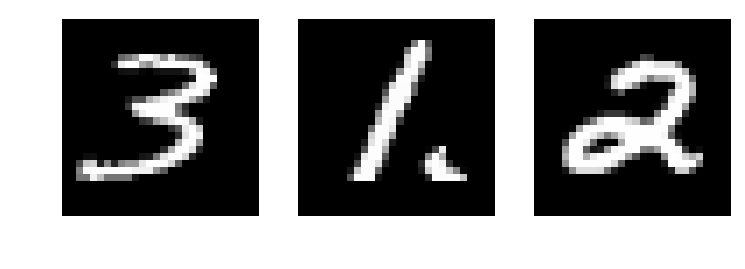

In [8]:
fig, ax = plt.subplots(1, 3, sharex=True, squeeze=True)
for _,x in zip(ax, [x_train, x_valid, x_test]):
    _.set_axis_off()
    __ = _.imshow(x[-1], cmap='gray');
plt.show()

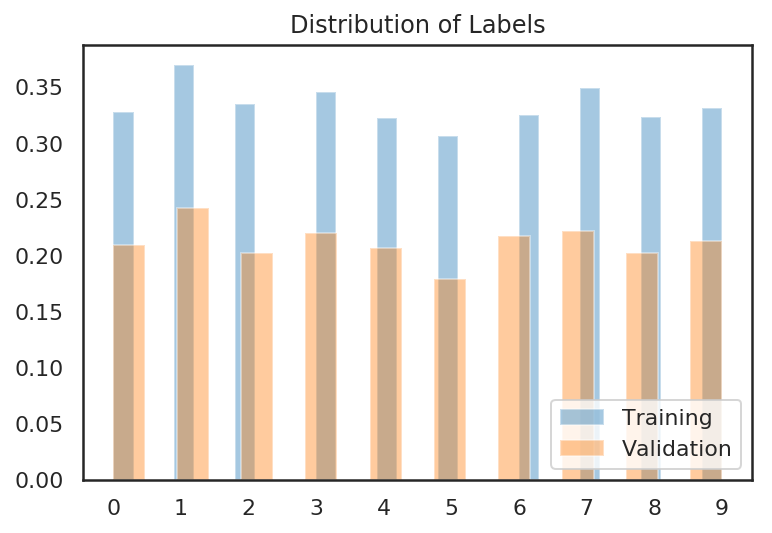

In [9]:
fig, ax = plt.subplots()
ax = sns.distplot(y_train, kde=False, norm_hist=True, label='Training')
ax = sns.distplot(y_valid, kde=False, norm_hist=True, label='Validation')
_ = ax.set_xticks(np.arange(0,10,1))
_ = plt.legend(loc='lower right')
_ = plt.title('Distribution of Labels')

## Visualize Dimensionality [TSNE]

In [10]:
from MulticoreTSNE import MulticoreTSNE as TSNE
import plotly

plotly.offline.init_notebook_mode(connected=True)
import plotly.offline as pltly
from plotly import tools
import plotly.graph_objs as plgo

def TSNE_3d(points, labels, title):
    
    data = []
    marks = lambda x: {'size':8,
                       'line':{'color':plt.cm.Set1(x/10.0)},
                       'opacity':0.75}
    
    x, y = points[:,0], points[:,1]
    
    for _num in range(10):
        idx = np.array(labels == _num).astype(np.bool).reshape(-1)
        scatter = plgo.Scatter(x = x[idx], y = y[idx],
                                 mode = 'markers',
                                 marker = marks(_num),
                                 text = [f'{_num}'],
                                 name = f'{_num}',
                                 hoverinfo='name')
        data.append(scatter)
    layout = plgo.Layout(margin={'l':0, 'r':0, 'b':0, 't':0},
                         title=title)
    fig = plgo.Figure(data=data, layout=layout)
    pltly.iplot(fig, filename=title)


In [11]:
start = time()
plotfor = 5000
plot = TSNE(n_components=2, 
            n_iter=1000,
            n_iter_without_progress=250,
            n_jobs=8,
            random_state=42).fit_transform(X=x_train[:plotfor].reshape(-1,784))

TSNE_3d(plot, y_train[:plotfor].reshape(-1), f'3D tSNE plot{(time()-start):.2f}s')

## Prepare Data for loading

### Albumentations Pipeline

image shape: torch.Size([1, 28, 28]), target: 5


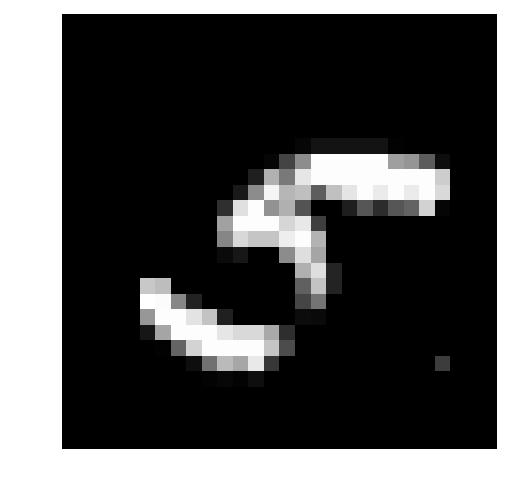

In [12]:
class ALBDataset(Dataset):

    def __init__(self, x=x_train, y=y_train,
                 transforms=None):
        super().__init__()

        self.x = x
        self.y = y
        self.transform = transforms
        
        if self.y is None:
            self.len = len(self.x)
        else:
            try:
                assert len(self.x) == len(self.y)
                self.len = len(self.x)
            except AssertionError:
                print(f'length of x={len(self.x)} is not equal to \
                        length of y={len(self.y)}')
            
    def __len__(self):

        return self.len

    def __getitem__(self, index):

        if self.y is not None:
            image, label = self.x[index], self.y[index]
            # HxWxC, UINT8
            image = np.expand_dims(image, -1).astype(np.uint8)
            label = tc.from_numpy(np.array(label)).type(tc.LongTensor)
        else:
            image, label = self.x[index], None
        
        
        # image = image.astype(np.uint8).reshape(28, 28, 1)
        # image = tc.from_numpy(image).type(tc.FloatTensor)

        if self.transform is not None:
            augmented = self.transform(image=image)
            image = augmented['image'].astype(np.uint8).reshape(28, 28, 1)
        
        image = transforms.ToTensor()(image)
        
        if self.y is None:
            return image
        else:
            return image, label

# test
test_set = ALBDataset()
img, labl = test_set.__getitem__(0)
print(f'image shape: {img.shape}, target: {labl}')
_ = plt.imshow(img.reshape(28, 28), cmap='gray')
_ = plt.axis('off')

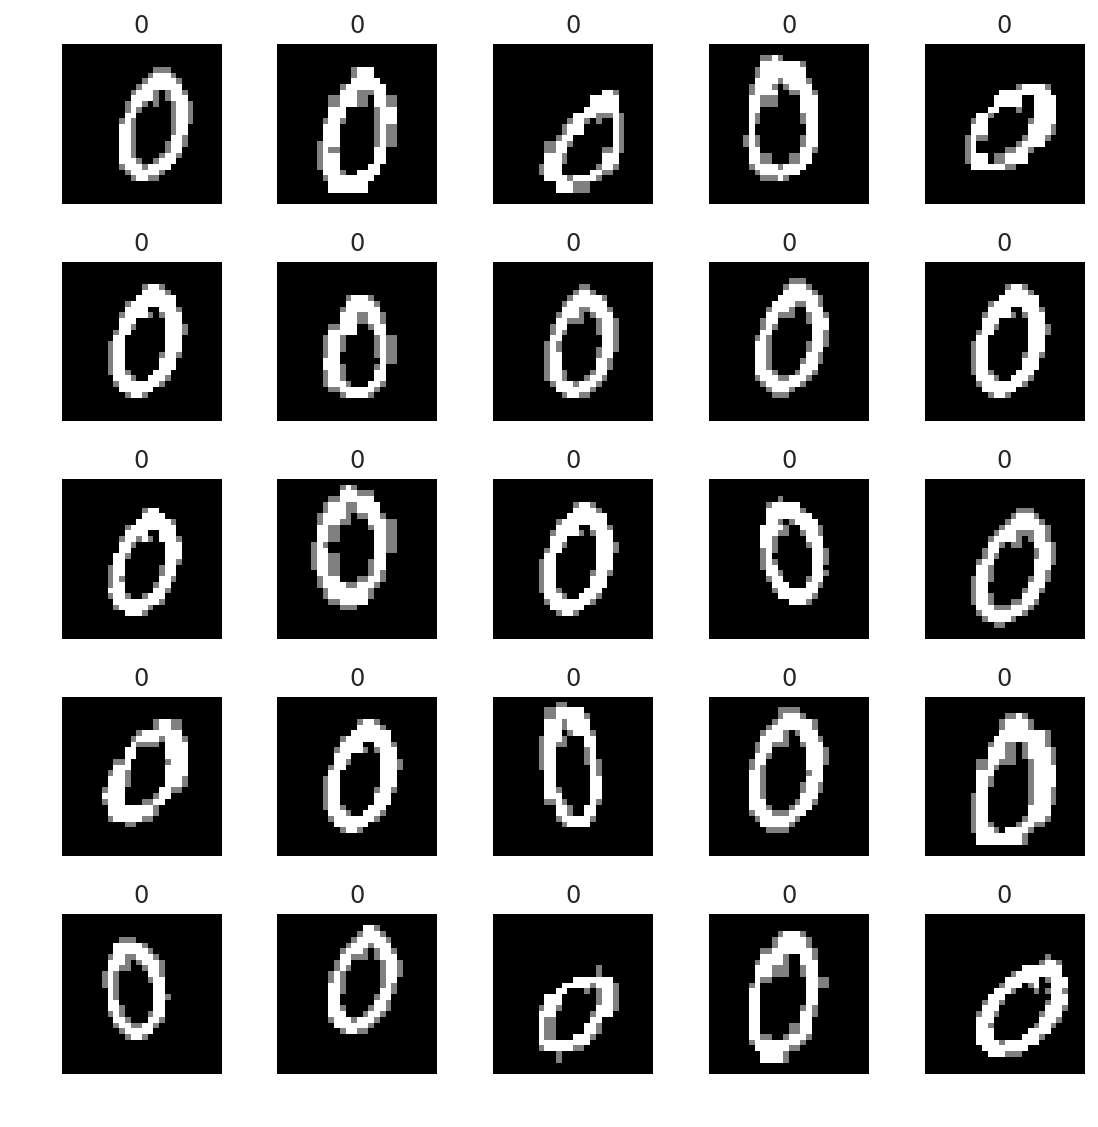

In [19]:
albumentations_transform = Compose([ShiftScaleRotate(shift_limit = 0.1,
                                                     scale_limit = 0.1,
                                                     rotate_limit = 30,
                                                     interpolation = cv2.INTER_LANCZOS4,
                                                     border_mode = cv2.BORDER_CONSTANT,
                                                     p = 0.75),
                                    OneOf([OpticalDistortion(border_mode = cv2.BORDER_CONSTANT,
                                                             p=1.0),
                                           GridDistortion(border_mode = cv2.BORDER_CONSTANT,
                                                          p=1.0)],
                                          p=0.75),
                                    Normalize(mean=[0.1307], std=[0.3081])])

albumentations_valtransform = Compose([Normalize(mean=[0.1307], std=[0.3081])])

# test
test_set = ALBDataset(transforms=albumentations_transform)

fig, axes = plt.subplots(5, 5, figsize=(8,8), sharex=True, sharey=True)
_plots = None

testnum = np.random.randint(0, 28000)
for axs in axes:
    for ax in axs:
        data = test_set.__getitem__(testnum)
        _ = ax.imshow(data[0].reshape(28, 28), cmap='gray');
        _ = ax.set_title(str(data[1].numpy()))
        _ = ax.set_axis_off()

plt.subplots_adjust(hspace=0.25)
plt.tight_layout()
plt.show()

In [21]:
def squeeze_targets(batch):
    # not needed
    data = tc.stack([item[0] for item in batch])
    target = tc.stack([item[1] for item in batch])
    
    return [data, target.view(-1)]

NN_trainloader = DataLoader(ALBDataset(transforms=albumentations_transform),
                            batch_size=420,
                            shuffle=True,
                            num_workers=8,
                            pin_memory=False)

NN_valloader = DataLoader(ALBDataset(x=x_valid, y=y_valid,
                                      transforms=albumentations_valtransform),
                           batch_size=420,
                           shuffle=True,
                           num_workers=8,
                           pin_memory=False)


NN_testloader = DataLoader(ALBDataset(x=x_valid, y=None,
                                      transforms=albumentations_valtransform),
                           batch_size=420,
                           shuffle=True,
                           num_workers=8,
                           pin_memory=False)

# test

img, lbl = next(iter(NN_trainloader))
print(img.shape, lbl.shape)
img, lbl = next(iter(NN_valloader))
print(img.shape, lbl.shape)
img = next(iter(NN_testloader))
print(img.shape)

torch.Size([420, 1, 28, 28]) torch.Size([420])
torch.Size([420, 1, 28, 28]) torch.Size([420])
torch.Size([420, 1, 28, 28])


In [ ]:
raw = x_train[:420].astype(np.float32).reshape(-1)/255
norm = next(iter(NN_trainloader))[0].numpy().reshape(-1)
bins = 10
_ = plt.hist(raw/255, bins=bins, density=True,
             cumulative=True, label='Raw', histtype='bar',
             alpha=0.75,log=True, color='g')

_ = plt.hist(norm, bins=bins, density=True,
             cumulative=True, label='Normalized',
             histtype='bar', alpha=0.75,
             log=True, color='y')

_ = plt.legend()
_ = plt.title('Input Pre v/s Post Normalization')

## Define NN Architecture

In [ ]:
# resnet-ish

def initialize_weights(module):
    if isinstance(module, nn.Conv2d):
        nn.init.kaiming_normal_(module.weight.data, mode='fan_out')
    elif isinstance(module, nn.BatchNorm2d):
        module.weight.data.fill_(1)
        module.bias.data.zero_()
    elif isinstance(module, nn.Linear):
        module.bias.data.zero_()


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride):
        super(BasicBlock, self).__init__()

        self.conv1 = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=3,
            stride=stride,  # downsample with first conv
            padding=1,
            bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(
            out_channels,
            out_channels,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut.add_module(
                'conv',
                nn.Conv2d(
                    in_channels,
                    out_channels,
                    kernel_size=1,
                    stride=stride,  # downsample
                    padding=0,
                    bias=False))
            self.shortcut.add_module('bn', nn.BatchNorm2d(out_channels))  # BN

    def forward(self, x):
        y = fu.relu(self.bn1(self.conv1(x)), inplace=True)
        y = self.bn2(self.conv2(y))
        y += self.shortcut(x)
        y = fu.relu(y, inplace=True)  # apply ReLU after addition
        return y


class BottleneckBlock(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride):
        super(BottleneckBlock, self).__init__()

        bottleneck_channels = out_channels // self.expansion

        self.conv1 = nn.Conv2d(
            in_channels,
            bottleneck_channels,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False)
        self.bn1 = nn.BatchNorm2d(bottleneck_channels)

        self.conv2 = nn.Conv2d(
            bottleneck_channels,
            bottleneck_channels,
            kernel_size=3,
            stride=stride,  # downsample with 3x3 conv
            padding=1,
            bias=False)
        self.bn2 = nn.BatchNorm2d(bottleneck_channels)

        self.conv3 = nn.Conv2d(
            bottleneck_channels,
            out_channels,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()  # identity
        if in_channels != out_channels:
            self.shortcut.add_module(
                'conv',
                nn.Conv2d(
                    in_channels,
                    out_channels,
                    kernel_size=1,
                    stride=stride,  # downsample
                    padding=0,
                    bias=False))
            self.shortcut.add_module('bn', nn.BatchNorm2d(out_channels))  # BN

    def forward(self, x):
        y = fu.relu(self.bn1(self.conv1(x)), inplace=True)
        y = fu.relu(self.bn2(self.conv2(y)), inplace=True)
        y = self.bn3(self.conv3(y))  # not apply ReLU
        y += self.shortcut(x)
        return y


class MNIST_CNN(nn.Module):
    def __init__(self, config):
        super(MNIST_CNN, self).__init__()

        input_shape = config['input_shape']
        n_classes = config['n_classes']

        base_channels = config['base_channels']
        block_type = config['block_type']
        depth = config['depth']

        assert block_type in ['basic', 'bottleneck']
        if block_type == 'basic':
            block = BasicBlock
            n_blocks_per_stage = (depth - 2) // 6
            assert n_blocks_per_stage * 6 + 2 == depth
        else:
            block = BottleneckBlock
            n_blocks_per_stage = (depth - 2) // 9
            assert n_blocks_per_stage * 9 + 2 == depth

        n_channels = [
            base_channels, base_channels * 2 * block.expansion,
            base_channels * 4 * block.expansion
        ]

        self.conv = nn.Conv2d(
            input_shape[1],
            n_channels[0],
            kernel_size=3,
            stride=1,
            padding=1,
            bias=False)
        self.bn = nn.BatchNorm2d(base_channels)

        self.stage1 = self._make_stage(
            n_channels[0], n_channels[0], n_blocks_per_stage, block, stride=1)
        self.stage2 = self._make_stage(
            n_channels[0], n_channels[1], n_blocks_per_stage, block, stride=2)
        self.stage3 = self._make_stage(
            n_channels[1], n_channels[2], n_blocks_per_stage, block, stride=2)

        # compute conv feature size
        with tc.no_grad():
            self.feature_size = self._forward_conv(
                tc.zeros(*input_shape)).view(-1).shape[0]

        self.pre_fc = nn.Linear(self.feature_size, self.feature_size*2)
        self.fc = nn.Linear(self.feature_size*2, n_classes)

        # initialize weights
        self.apply(initialize_weights)

    def _make_stage(self, in_channels, out_channels, n_blocks, block, stride):
        stage = nn.Sequential()
        for index in range(n_blocks):
            block_name = 'block{}'.format(index + 1)
            if index == 0:
                stage.add_module(
                    block_name, block(
                        in_channels, out_channels, stride=stride))
            else:
                stage.add_module(block_name,
                                 block(out_channels, out_channels, stride=1))
        return stage

    def _forward_conv(self, x):
        x = fu.relu(self.bn(self.conv(x)), inplace=True)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = fu.adaptive_avg_pool2d(x, output_size=1)
        return x

    def forward(self, x):
        x = self._forward_conv(x)
        x = x.view(x.size(0), -1)
        x = fu.dropout(fu.relu(self.pre_fc(x)), p=0.25)
        x = self.fc(x)
        return x

In [ ]:
# test

config = {'input_shape':(1,1,28,28),
          'n_classes':10,
          'block_type':'bottleneck',
          'base_channels':64,
          'depth':11}

test_cnn = MNIST_CNN(config).cuda()
print(summary(test_cnn.cuda(), (1,28,28), device='cuda'))
hl.build_graph(model=test_cnn.cuda(), args=tc.randn(1,1,28,28).cuda())

## Prepare for Training

In [ ]:
class CNN_trainer():

    def __init__(self, cfg, filename, 
                 trainloader, testloader, lr=0.001,  
                 savedir='./saves', savevery=5,
                 wcuda=True, starting_epoch=0):
        
        self.model = MNIST_CNN(config=cfg)
    
        self.trainloader = trainloader
        self.testloader = testloader
        
        self.lr = lr
        self.lossfn = fu.cross_entropy
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        self.metrics = {'accuracy':Accuracy(),
                        'loss':Loss(self.lossfn)}
        self.trn_records = {k:[] for k in self.metrics.keys()}
        self.val_records = {k:[] for k in self.metrics.keys()}
        self.bwise_losses = []
        
        if wcuda:
            self.wcuda, self.device = True, 'cuda'
        else:
            self.wcuda, self.device = False, 'cpu'
            
        self.savevery = savevery     
        self.savedir = savedir
        self.filename = filename
        self.run = self.__call__
        if starting_epoch > 0:
            try:
                self.loadstates(False)
            except:
                print(f'model state for {self.filename}_final.pth \
                        could not be loaded!, starting anew.')
                self.epoch = 0
        else:
            self.epoch = 0
        
    def loadstate(self, loadbest=True):
            
        if loadbest:
            path = self.savedir+'/'+self.filename+'_best.pth'
        else:
            path = self.savedir+'/'+self.filename+'_final.pth'
        if os.path.isfile(path):
            print(f'file {path} found')
            chkpt = tc.load(path)
            try:
                self.model.load_state_dict(chkpt['model_state_dict'])
                self.optimizer.load_state_dict(chkpt['optimizer_state'])
                self.epoch = chkpt['epoch']
            except:
                print('model state could not be loaded,\
                        check if model matches weights file')
        else:
            print(f'file at {path} does not exist!')
            raise FileNotFoundError
    
    def __call__(self, max_epochs, log_interval):
        
        gc.collect()
        if self.wcuda:
            tc.backends.cudnn.enabled = True
            tc.cuda.empty_cache()
            
        desc = "ITERATION - loss: {:.6f}"
        pbar = tqdm(initial=0, leave=False, total=len(self.trainloader),
                    desc=desc.format(0))
        
        trainer = create_supervised_trainer(self.model,
                                            self.optimizer,
                                            self.lossfn,
                                            device=self.device,
                                            non_blocking=True)

        evaluator = create_supervised_evaluator(self.model,
                                                self.metrics,
                                                device=self.device,
                                                non_blocking=True)
        @trainer.on(Events.STARTED)
        def start_at_epoch(engine):
            if engine.state.epoch != self.epoch:
                pbar.write(f'Starting from epoch:{self.epoch}')
                engine.state.epoch = self.epoch
                
        @trainer.on(Events.ITERATION_COMPLETED)
        def log_training_losses(engine):
            
            iter = (engine.state.iteration - 1) % len(self.trainloader) + 1
            
            if iter % log_interval == 0:
                pbar.desc = desc.format(engine.state.output)
                pbar.update(log_interval)
            
            records = engine.state.output
            print(engine.state.metrics.keys())
            self.bwise_losses.append(records)
            
        @trainer.on(Events.EPOCH_COMPLETED)
        def log_training_results(engine):
            self.epoch = engine.state.epoch
            pbar.refresh()
            self.model.eval()
            evaluator.run(self.trainloader)
            metrics = evaluator.state.metrics
            avg_accuracy = metrics['accuracy']
            avg_nll = metrics['loss']

            tqdm_str = "Training Results - Epoch: {}  \
                        Avg accuracy: {:.6f} Avg loss: {:.6f}"
            pbar.write(tqdm_str.format(engine.state.epoch,
                                        avg_accuracy, avg_nll))

            for k in self.metrics.keys():
                self.trn_records[k].append(metrics[k])
            self.model.train()

        @trainer.on(Events.EPOCH_COMPLETED)
        def log_validation_results(engine):
            self.model.eval()
            evaluator.run(self.testloader)
            metrics = evaluator.state.metrics
            avg_accuracy = metrics['accuracy']
            avg_nll = metrics['loss']

            tqdm_str = "Validation Results - Epoch: {}  \
                        Avg accuracy: {:.6f} Avg loss: {:.6f}"
            pbar.write(tqdm_str.format(engine.state.epoch,
                                        avg_accuracy, avg_nll))
            pbar.n = pbar.last_print_n = 0

            for k in self.metrics.keys():
                self.val_records[k].append(metrics[k])
            self.model.train()
                
        @trainer.on(Events.EPOCH_COMPLETED)
        def save_model(engine):
            checkin = self.val_records['accuracy']
            filename = f'{self.filename}_best.pth'
            tqdm_str = f'Saving Model... to {self.savedir} \
                        as {filename}'
            if engine.state.epoch % self.savevery == 0:
                if checkin[-1] > np.mean(checkin):
                    pbar.write(tqdm_str)
                    self.model.eval()
                    savedict = {'model_object':self.model,
                                'model_state_dict':self.model.state_dict,
                                'optimizer_state':self.optimizer.state_dict,
                                'epoch':engine.state.epoch,
                                'accuracy':self.trn_records['accuracy'],
                                'loss':self.trn_records['loss']}
                    tc.save(savedict, self.savedir+'/'+filename)
                else:
                    pbar.write('Non-Optimal Model State, Skipping Saving..')
            self.model.train()
                    
        @trainer.on(Events.COMPLETED)
        def save_final_model(engine):
            filename = f'{self.filename}_final.pth'
            tqdm_str = f'Saving Final Model... to {self.savedir} \
                        as {filename}'
            pbar.write(tqdm_str)
            self.model.eval()
            savedict = {'model_object':self.model,
                        'model_state_dict':self.model.state_dict,
                        'optimizer_state':self.optimizer.state_dict,
                        'epoch':engine.state.epoch,
                        'accuracy':self.trn_records['accuracy'],
                        'loss':self.trn_records['loss']}
            tc.save(savedict, self.savedir+'/'+filename)
            self.model.train()
            
        self.max_epochs = max_epochs
        trainer.run(self.trainloader, max_epochs)
        pbar.close()
        
    def plot(self, prefix='Base'):
        
        fig = plt.figure(figsize=(12,6))
        ax = plt.subplot(111)
        ax2 = ax.twinx().twiny()
        plt.rc('grid', linestyle="--", color='gray')
        plt.minorticks_on()
        
        plots = [self.trn_records['accuracy'],
                 self.trn_records['loss'],
                 self.val_records['accuracy'],
                 self.val_records['loss']]
        
        labels = ['Training Accuracy',
                  'Training Loss',
                  'Validation Accuracy',
                  'Validation Loss']
        
        colors = ['xkcd:lime', 'xkcd:green', 'xkcd:red', 'xkcd:cerise']
        linestyles = ['-', '--', '-', '--']
        markers = ['o', '+', 'x', '*']


        for series, lab, col, ls, mrk in zip(plots, labels, colors, linestyles, markers):
            ax.plot(series, marker=mrk, linewidth=1, label=lab, color=col, linestyle=ls)
            ax.set_xlabel('Epochs')

        ax2.plot(self.bwise_losses, label='Batchwise Losses', alpha=0.5,
                    color='blue', linestyle='--', linewidth=1)
        ax2.set_xlabel('Batches', color='blue')
        ax2.xaxis.set_ticks_position('bottom')
        ax2.xaxis.set_label_position('bottom')
        ax2.spines['bottom'].set_position(('axes', -0.20))
        ax2.spines['bottom'].set_color('blue')
        ax2.spines['right'].set_color('blue')
        ax2.yaxis.tick_right()
        ax2.yaxis.set_label_position("right")
        ax2.tick_params(axis='y', colors='blue')

        ax.legend(loc='center left', frameon=True, bbox_to_anchor=(1.05, 0.5),
                      ncol=1, fancybox=True)
        ax2.legend(loc='center left', frameon=True, bbox_to_anchor=(1.05, 0.75),
                      ncol=1, fancybox=True)
        ax.grid(which='major', color='black', linestyle='--')
        ax.grid(which='minor', color='gray', linestyle=':')
        plt.title(label=f'Model: {prefix}', loc='center')
  
        plt.show()

## Train and Visualize Results

In [ ]:
config1 = {'input_shape':(1,1,28,28),
          'n_classes':10,
          'block_type':'bottleneck',
          'base_channels':64,
          'depth':11}

config2 = {'input_shape':(1,1,28,28),
          'n_classes':10,
          'block_type':'basic',
          'base_channels':64,
          'depth':8}

config3 = {'input_shape':(1,1,28,28),
          'n_classes':10,
          'block_type':'basic',
          'base_channels':64,
          'depth':14}

config4 = {'input_shape':(1,1,28,28),
          'n_classes':10,
          'block_type':'basic',
          'base_channels':64,
          'depth':20}


models_dict = {1:(config1, 'MNIST_RESN_BNECK_64x11'),
               2:(config2, 'MNIST_RESN_BASIC_64x8'),
               3:(config3, 'MNIST_RESN_BASIC_64x14'),
               4:(config4, 'MNIST_RESN_BASIC_64x20')}


trainer_dict = {x:CNN_trainer(*models_dict[x], NN_trainloader, NN_valloader) \
                for x in models_dict.keys()}

In [ ]:
# 1
trainer_dict[1](150, log_interval=1)
trainer_dict[1].plot()

In [ ]:
# 1
trainer_dict[2](150, log_interval=1)
trainer_dict[2].plot()

In [ ]:
# 1
trainer_dict[3](150, log_interval=1)
trainer_dict[3].plot()

In [ ]:
# 1
trainer_dict[4](150, log_interval=1)
trainer_dict[4].plot()

## Ensemble predictors and predict for testset

In [ ]:
def to_np(v):
    if isinstance(v, (np.ndarray, np.generic)): return v
    if isinstance(v, (list,tuple)): return [to_np(o) for o in v]
    if isinstance(v, Variable): v=v.data
    if tc.cuda.is_available():
        if isinstance(v, tc.cuda.HalfTensor): v=v.float()
    if isinstance(v, tc.FloatTensor): v=v.float()
    return v.cpu().numpy()


def predict(model, testloader, batch_size=140):
    
    model.eval()
    tc.cuda.empty_cache()
    
    target = np.zeros(len(test_set))
    
    for idx, img in enumerate(next(iter(testloader))):
        
        batch_size = len(img)
        output = np.zeros((batch_size, 10), dtype='float32')
        
        img = img.to('cuda',dtype=tc.float,
                     non_blocking=True,copy=False)
        output += to_np(model.forward(img))
        target[idx:idx+batch_size] = np.argmax(output, -1)
        fig, axes = plt.subplots(1,10)
        for ix, ax in enumerate(axes):
            ax.imshow(img[ix].cpu().reshape(28,28))
        print(output[0:10])
        break
        
    return target